<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/Meteorology_replace-missing-values/blob/master/Replace_Missing_Values_Temperature%5BMacapa%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Leitura de dados
dataSet = pd.read_csv("https://github.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/raw/master/DadosDiarios/macapadiario.csv",
                      sep=';',skiprows=16)

In [0]:
#Transformando data em variável do tipo datetime
dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")

In [4]:
#Descrevendo base de dados
dataSet.describe()

,Estacao,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
count,27238.0,27238.000000,13638.000000,13181.000000,13397.000000,13218.000000,13423.000000,13178.000000,11544.000000,13558.000000,0.0
mean,82098.0,601.277627,6.962216,31.635771,23.842547,6.697874,2.761551,27.186084,81.486227,2.000683,NaN
std,0.0,600.009654,14.240079,1.830345,0.904936,3.214596,1.585277,1.267593,7.905563,1.204566,NaN
min,82098.0,0.000000,0.000000,24.500000,19.600000,0.000000,0.000000,21.800000,55.000000,0.000000,NaN
25%,82098.0,0.000000,0.000000,30.600000,23.200000,4.400000,1.500000,26.280000,75.500000,1.000000,NaN
50%,82098.0,1200.000000,0.300000,31.900000,23.800000,7.600000,2.400000,27.280000,82.250000,2.000000,NaN
75%,82098.0,1200.000000,7.800000,33.000000,24.400000,9.500000,3.900000,28.200000,87.750000,2.866667,NaN
max,82098.0,1200.000000,215.800000,39.600000,28.500000,14.400000,20.400000,32.600000,98.500000,6.433333,NaN


In [5]:
#Verificando dados
dataSet.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
0,82098,1980-01-01,0,NaN,30.8,NaN,6.1,1.2,27.04,NaN,3.700000,NaN
1,82098,1980-01-01,1200,11.0,NaN,23.6,NaN,NaN,NaN,NaN,NaN,NaN
2,82098,1980-01-02,0,NaN,31.4,NaN,8.3,2.8,27.38,NaN,3.633333,NaN
3,82098,1980-01-02,1200,0.6,NaN,23.2,NaN,NaN,NaN,NaN,NaN,NaN
4,82098,1980-01-03,0,NaN,30.3,NaN,3.7,2.8,26.98,NaN,3.900000,NaN


In [0]:
#Atribuindo "Data" como índice para a base de dados
dataSet = dataSet.set_index("Data")

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]

In [0]:
#Descartando as colunas "Hora", "Estacao" e "Unnamed: 11" 
dataSet00, dataSet12 = dataSet00.drop(columns = ["Hora", "Estacao", "Unnamed: 11"]), dataSet12.drop(columns = ["Hora", "Estacao", "Unnamed: 11"])

In [9]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
dataSet00.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,0.0,13181.000000,0.0,13218.000000,13423.000000,13178.000000,11544.000000,13558.000000
mean,NaN,31.635771,NaN,6.697874,2.761551,27.186084,81.486227,2.000683
std,NaN,1.830345,NaN,3.214596,1.585277,1.267593,7.905563,1.204566
min,NaN,24.500000,NaN,0.000000,0.000000,21.800000,55.000000,0.000000
25%,NaN,30.600000,NaN,4.400000,1.500000,26.280000,75.500000,1.000000
50%,NaN,31.900000,NaN,7.600000,2.400000,27.280000,82.250000,2.000000
75%,NaN,33.000000,NaN,9.500000,3.900000,28.200000,87.750000,2.866667
max,NaN,39.600000,NaN,14.400000,20.400000,32.600000,98.500000,6.433333


In [10]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
dataSet12.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,13638.000000,0.0,13397.000000,0.0,0.0,0.0,0.0,0.0
mean,6.962216,NaN,23.842547,NaN,NaN,NaN,NaN,NaN
std,14.240079,NaN,0.904936,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,19.600000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,23.200000,NaN,NaN,NaN,NaN,NaN
50%,0.300000,NaN,23.800000,NaN,NaN,NaN,NaN,NaN
75%,7.800000,NaN,24.400000,NaN,NaN,NaN,NaN,NaN
max,215.800000,NaN,28.500000,NaN,NaN,NaN,NaN,NaN


In [0]:
#Eliminando colunas completas por "NaN" em cada uma das bases de dados
dataSet00 = dataSet00.drop(columns = ["Precipitacao","TempMinima"])
dataSet12 = dataSet12.drop(columns = ["TempMaxima","Insolacao","Evaporacao Piche","Temp Comp Media","Umidade Relativa Media","Velocidade do Vento Media"])

In [12]:
#Exibindo a base de dados recém filtrada para 00:00 h
dataSet00.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
Data,,,,,,
1980-01-01,30.8,6.1,1.2,27.04,NaN,3.700000
1980-01-02,31.4,8.3,2.8,27.38,NaN,3.633333
1980-01-03,30.3,3.7,2.8,26.98,NaN,3.900000
1980-01-04,31.0,6.2,2.6,27.48,NaN,4.333333
1980-01-05,30.2,5.6,3.8,26.52,NaN,4.433333


In [13]:
#Exibindo a base de dados recém filtrada para 12:00 h
dataSet12.head()

,Precipitacao,TempMinima
Data,,
1980-01-01,11.0,23.6
1980-01-02,0.6,23.2
1980-01-03,1.0,23.6
1980-01-04,1.1,24.4
1980-01-05,1.7,24.2


In [0]:
#Criando o intervalo completo de tempo de 01-01-1980 à 31-12-2017
dataInicial = '1980-01-01'
dataFinal = '2017-12-31'
tempo = pd.date_range(dataInicial, dataFinal)
#Atribuindo este intervalo de tempo à um dataSet provisório
dataSetProv = pd.DataFrame()
dataSetProv["Data"] = tempo

In [0]:
#Atribuindo o índice para o dataSet provisório como sendo a coluna de datas
dataSetProv = dataSetProv.set_index("Data")

In [16]:
#Visualizando o dataSet provisório
dataSetProv.head()

""
Data
1980-01-01
1980-01-02
1980-01-03
1980-01-04
1980-01-05


In [0]:
#Mesclando o dataSet provisório como sendo o resultado da junção dos dataSet00 e dataSet12
dataSetProv = dataSetProv.join(dataSet00).join(dataSet12)

In [18]:
#Mostrando o resultado da junção
dataSetProv.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,30.8,6.1,1.2,27.04,NaN,3.700000,11.0,23.6
1980-01-02,31.4,8.3,2.8,27.38,NaN,3.633333,0.6,23.2
1980-01-03,30.3,3.7,2.8,26.98,NaN,3.900000,1.0,23.6
1980-01-04,31.0,6.2,2.6,27.48,NaN,4.333333,1.1,24.4
1980-01-05,30.2,5.6,3.8,26.52,NaN,4.433333,1.7,24.2


In [19]:
#Quantidade de dias existentes na base de dados
len(dataSetProv)

13880

In [0]:
#Tornando o dataSet como sendo o dataSet provisório
dataSet = dataSetProv

In [21]:
#Descrevendo o novo dataSet
dataSet.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,13181.000000,13218.000000,13423.000000,13178.000000,11544.000000,13558.000000,13638.000000,13397.000000
mean,31.635771,6.697874,2.761551,27.186084,81.486227,2.000683,6.962216,23.842547
std,1.830345,3.214596,1.585277,1.267593,7.905563,1.204566,14.240079,0.904936
min,24.500000,0.000000,0.000000,21.800000,55.000000,0.000000,0.000000,19.600000
25%,30.600000,4.400000,1.500000,26.280000,75.500000,1.000000,0.000000,23.200000
50%,31.900000,7.600000,2.400000,27.280000,82.250000,2.000000,0.300000,23.800000
75%,33.000000,9.500000,3.900000,28.200000,87.750000,2.866667,7.800000,24.400000
max,39.600000,14.400000,20.400000,32.600000,98.500000,6.433333,215.800000,28.500000


In [22]:
#Mostrando o cabeçalho do novo dataSet
dataSet.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,30.8,6.1,1.2,27.04,NaN,3.700000,11.0,23.6
1980-01-02,31.4,8.3,2.8,27.38,NaN,3.633333,0.6,23.2
1980-01-03,30.3,3.7,2.8,26.98,NaN,3.900000,1.0,23.6
1980-01-04,31.0,6.2,2.6,27.48,NaN,4.333333,1.1,24.4
1980-01-05,30.2,5.6,3.8,26.52,NaN,4.433333,1.7,24.2


# Modelagem para previsão de Temperatura Máxima

In [0]:
#Separando base de dados para treino de rede neural para previsão de temperatura máxima
dataTreinoTempMax = dataSet.dropna(subset = ["TempMaxima"])

In [0]:
#Separando a variável que será prevista, TempMaxima, da base de dados
tempMax = dataTreinoTempMax["TempMaxima"]
dataTreinoTempMax = dataTreinoTempMax.drop(columns = "TempMaxima")

In [25]:
#Visualizando cabeçalho dos dados para treino
dataTreinoTempMax.head()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,
1980-01-01,6.1,1.2,27.04,NaN,3.700000,11.0,23.6
1980-01-02,8.3,2.8,27.38,NaN,3.633333,0.6,23.2
1980-01-03,3.7,2.8,26.98,NaN,3.900000,1.0,23.6
1980-01-04,6.2,2.6,27.48,NaN,4.333333,1.1,24.4
1980-01-05,5.6,3.8,26.52,NaN,4.433333,1.7,24.2


In [26]:
#Visualizando cabeçalho das informações de temperatura 
tempMax.head()

Data
1980-01-01    30.8
1980-01-02    31.4
1980-01-03    30.3
1980-01-04    31.0
1980-01-05    30.2
Name: TempMaxima, dtype: float64

In [0]:
#Guardando a informação de como as colunas estão distribuídas no dataFrame
colunas = dataTreinoTempMax.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMax = mms.fit_transform(dataTreinoTempMax)

In [29]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMax)
prov.columns = colunas
prov.describe()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,12840.000000,13100.000000,13175.000000,11218.000000,13149.000000,13169.000000,13173.000000
mean,-0.068304,-0.730877,-0.002594,0.213985,-0.374582,-0.935567,-0.047072
std,0.446231,0.153790,0.234748,0.363821,0.375520,0.131737,0.203520
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.388889,-0.852941,-0.170370,-0.068966,-0.689119,-1.000000,-0.191011
50%,0.055556,-0.764706,0.014815,0.252874,-0.378238,-0.997220,-0.056180
75%,0.319444,-0.617647,0.185185,0.505747,-0.098446,-0.927711,0.078652
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0 
dataTreinoTempMax = np.nan_to_num(dataTreinoTempMax, copy = False)

In [31]:
#Verificando dimensões do dataSet
print(dataTreinoTempMax.shape)

(13181, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMax, X_testTempMax, Y_trainTempMax, Y_testTempMax = train_test_split(dataTreinoTempMax, tempMax, test_size = 0.1, random_state = 9)

In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='adam', init='random_uniform', units = 7, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = units, units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer = init, bias_initializer='zeros'))    
  # Compilando o modelo
  mlp.compile(loss='mean_squared_error', optimizer = optimizer, metrics= ['mae'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMax = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [38]:
#Busca pelos melhores parâmetros
grid_resultTempMax = grid_searchTempMax.fit(X_trainTempMax, Y_trainTempMax)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 1s - loss: 741.7906 - mean_absolute_error: 27.0605
Epoch 2/200
 - 1s - loss: 410.2365 - mean_absolute_error: 20.0929
Epoch 3/200
 - 1s - loss: 212.0477 - mean_absolute_error: 14.3665
Epoch 4/200
 - 1s - loss: 94.3521 - mean_absolute_error: 9.4494
Epoch 5/200
 - 1s - loss: 33.8912 - mean_absolute_error: 5.4536
Epoch 6/200
 - 1s - loss: 10.0384 - mean_absolute_error: 2.7778
Epoch 7/200
 - 1s - loss: 4.0761 - mean_absolute_error: 1.6745
Epoch 8/200
 - 1s - loss: 3.3648 - mean_absolute_error: 1.4640
Epoch 9/200
 - 1s - loss: 3.3342 - mean_absolute_error: 1.4446
Epoch 10/200
 - 1s - loss: 3.3335 - mean_absolute_error: 1.4428
Epoch 11/200
 - 1s - loss:

In [39]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMax.best_score_, grid_resultTempMax.best_params_))
means = grid_resultTempMax.cv_results_['mean_test_score']
stds = grid_resultTempMax.cv_results_['std_test_score']
params = grid_resultTempMax.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.473116, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-0.473116 (0.015529) {'batch_size': 10, 'camadas': 2, 'units': 7}


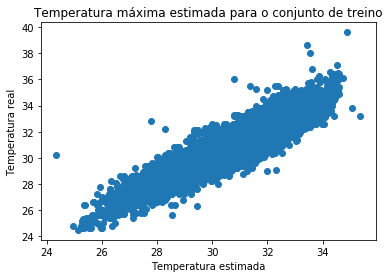

In [40]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax)
plt.title("Temperatura máxima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [41]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax))

[[1.         0.92932692]
 [0.92932692 1.        ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_predTempMax = grid_searchTempMax.predict(X_testTempMax)

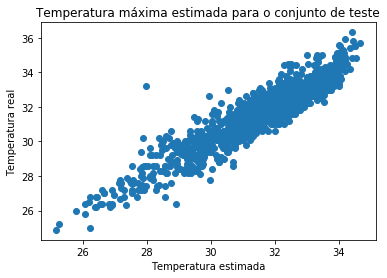

In [43]:
#Gráfico que mostra a relação entre a temperatura máxima real e a prevista para o conjunto de teste
plt.scatter(Y_predTempMax, Y_testTempMax)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [44]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMax, Y_testTempMax))

[[1.         0.93544152]
 [0.93544152 1.        ]]


In [45]:
#Erro absoluto médio entre a temperatura máxima prevista e a real
print(mean_absolute_error(Y_testTempMax, Y_predTempMax))

0.49044379175748665


In [46]:
#Erro quadrático médio entre a temperatura máxima prevista e a real
print(mean_squared_error(Y_testTempMax, Y_predTempMax))

0.42803844262849156


# Modelagem para previsão de Temperatura Mínima

In [0]:
#Separando dados para treinar rede neural para previsão de temperatura mínima
dataTreinoTempMin = dataSet.dropna(subset = ["TempMinima"])

In [0]:
#Separando a variável que será prevista, TempMinima, da base de dados
tempMin = dataTreinoTempMin["TempMinima"]
dataTreinoTempMin = dataTreinoTempMin.drop(columns = "TempMinima")

In [49]:
#Visualizando dados de treino para temperatura mínima
dataTreinoTempMin.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
Data,,,,,,,
1980-01-01,30.8,6.1,1.2,27.04,NaN,3.700000,11.0
1980-01-02,31.4,8.3,2.8,27.38,NaN,3.633333,0.6
1980-01-03,30.3,3.7,2.8,26.98,NaN,3.900000,1.0
1980-01-04,31.0,6.2,2.6,27.48,NaN,4.333333,1.1
1980-01-05,30.2,5.6,3.8,26.52,NaN,4.433333,1.7


In [50]:
#Visualizando informações de temperatura mínima para cada um dos dados de treino 
tempMin.head()

Data
1980-01-01    23.6
1980-01-02    23.2
1980-01-03    23.6
1980-01-04    24.4
1980-01-05    24.2
Name: TempMinima, dtype: float64

In [0]:
#Guardando informação de como as colunas estão distribuídas no dataFrame 
colunas = dataTreinoTempMin.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMin = mms.fit_transform(dataTreinoTempMin)

In [53]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMin)
prov.columns = colunas
prov.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
count,13173.000000,13055.000000,13315.000000,13173.000000,11434.000000,13366.000000,13387.000000
mean,-0.054896,-0.068186,-0.728485,-0.116083,0.214162,-0.375344,-0.935795
std,0.242462,0.445899,0.155592,0.260990,0.362841,0.374373,0.131448
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.192053,-0.388889,-0.852941,-0.303093,-0.068966,-0.689119,-1.000000
50%,-0.019868,0.055556,-0.764706,-0.096907,0.241379,-0.378238,-0.997220
75%,0.125828,0.319444,-0.617647,0.092784,0.505747,-0.108808,-0.927711
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreinoTempMin = np.nan_to_num(dataTreinoTempMin, copy = False)

In [55]:
#Verificando dimensões do dataSet
print(dataTreinoTempMin.shape)

(13397, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMin, X_testTempMin, Y_trainTempMin, Y_testTempMin = train_test_split(dataTreinoTempMin, tempMin, test_size = 0.1, random_state = 9)

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMin = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [61]:
#Busca pelos melhores parâmetros
grid_resultTempMin = grid_searchTempMin.fit(X_trainTempMin, Y_trainTempMin)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Epoch 1/200
 - 1s - loss: 379.6238 - mean_absolute_error: 19.3115
Epoch 2/200
 - 1s - loss: 161.7699 - mean_absolute_error: 12.5780
Epoch 3/200
 - 1s - loss: 58.3417 - mean_absolute_error: 7.4720
Epoch 4/200
 - 1s - loss: 15.1199 - mean_absolute_error: 3.6763
Epoch 5/200
 - 1s - loss: 2.7494 - mean_absolute_error: 1.4030
Epoch 6/200
 - 1s - loss: 0.9163 - mean_absolute_error: 0.7499
Epoch 7/200
 - 1s - loss: 0.8208 - mean_absolute_error: 0.7089
Epoch 8/200
 - 1s - loss: 0.8201 - mean_absolute_error: 0.7101
Epoch 9/200
 - 1s - loss: 0.8201 - mean_absolute_error: 0.7100
Epoch 10/200
 - 1s - loss: 0.8203 - mean_absolute_error: 0.7098
Epoch 11/200
 - 1s - loss: 0.8204 - mean_absolute_error: 0.7100
Epoch 12/200
 - 1s - loss: 0.8210 - mean_absolute_error: 0.7103
Epoch 13/200
 - 1s - l

In [62]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMin.best_score_, grid_resultTempMin.best_params_))
means = grid_resultTempMin.cv_results_['mean_test_score']
stds = grid_resultTempMin.cv_results_['std_test_score']
params = grid_resultTempMin.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.376068, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-0.376068 (0.012883) {'batch_size': 10, 'camadas': 2, 'units': 7}


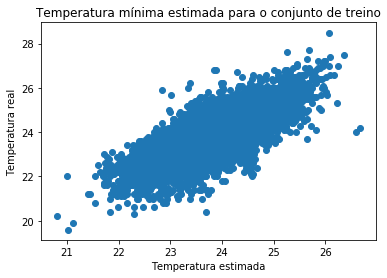

In [63]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin)
plt.title("Temperatura mínima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [64]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin))

[[1.         0.75306338]
 [0.75306338 1.        ]]


In [0]:
#Previsão para os dados de teste a partir da modelagem obtida
Y_predTempMin = grid_searchTempMin.predict(X_testTempMin)

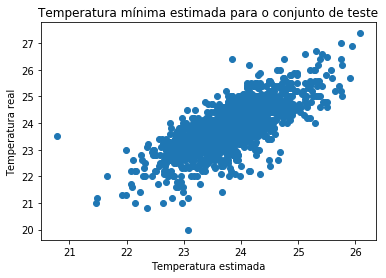

In [66]:
#Gráfico que mostra a relação entre a temperatura mínima real e a temperatura mínima prevista para os dados de teste
plt.scatter(Y_predTempMin, Y_testTempMin)
plt.title("Temperatura mínima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [67]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMin, Y_testTempMin))

[[1.         0.74261168]
 [0.74261168 1.        ]]


In [68]:
#Erro absoluto médio entre temperatura mínima real e prevista para os dados de teste
print(mean_absolute_error(Y_testTempMin, Y_predTempMin))

0.4698059247145013


In [69]:
#Erro quadrático médio entre a temperatura mínima real e a prevista para os dados de teste
print(mean_squared_error(Y_testTempMin, Y_predTempMin))

0.37507696121868733


In [70]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pickle
# Salvando os modelos treinados
filename = '/content/gdrive/My Drive/TemperaturaMaximaMacapa.sav'
pickle.dump(grid_searchTempMax, open(filename, 'wb'))

In [0]:
filename = '/content/gdrive/My Drive/TemperaturaMinimaMacapa.sav'
pickle.dump(grid_searchTempMin, open(filename, 'wb'))